In [28]:
import collections
import datetime
# import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
# import tensorflow as tf
# from tensorflow import keras
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

#pytorch stuff
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset  # Importing data utilities from PyTorch.
import torch.nn as nn  # Base class for all neural network modules.
import torch.nn.functional as F  # Contains functions that don't have any parameters.
from torch.nn.functional import one_hot

device = torch.device('cuda' if torch.cuda.is_available() else cpu)
data_dir = pathlib.Path('C:/Users/oubra/OneDrive/Documents/maestro-v3.0.0-midi/maestro-v3.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

#Print some information about the first 10 notes in the instrument track.
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

# Define a function to convert MIDI data to notes in a pandas DataFrame.
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

    # Return the notes as a pandas DataFrame
  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head(4)
# def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
#   waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
#   # Take a sample of the generated waveform to mitigate kernel resets
#   waveform_short = waveform[:seconds*_SAMPLING_RATE]
#   return display.Audio(waveform_short, rate=_SAMPLING_RATE)

Number of files: 1276
C:\Users\oubra\OneDrive\Documents\maestro-v3.0.0-midi\maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917


In [56]:
# Set the number of MIDI files to be processed.
num_files = 50

# Create an empty list to store the notes DataFrames.
all_notes = []

# Iterate over the first num_files MIDI files in the filenames list.
for f in filenames[:num_files]:
  # Convert each MIDI file to a DataFrame of notes using the midi_to_notes function and append the DataFrame to the list.
  notes = midi_to_notes(f)
  all_notes.append(notes)

# Concatenate all the notes DataFrames into one DataFrame.
all_notes = pd.concat(all_notes)


In [57]:
# Get the total number of notes in the DataFrame.
n_notes = len(all_notes)
print(all_notes.shape)
print('Number of notes parsed:', n_notes)

(299680, 5)
Number of notes parsed: 299680


In [58]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

# Prepare dataset
class MidiDataset(Dataset):
    def __init__(self, notes_df, seq_length):
        self.notes = notes_df.values  # Convert DataFrame to numpy array
        self.seq_length = seq_length

    def __len__(self):
        return len(self.notes) - self.seq_length

    def __getitem__(self, index):
        sequence = torch.from_numpy(self.notes[index:index+self.seq_length]).float()
        label = torch.from_numpy(self.notes[index+self.seq_length]).float()
        return sequence, label

# Hyperparameters
seq_length = 25
batch_size = 64
num_epochs = 120

# Create DataLoader
dataset = MidiDataset(all_notes, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model
class MidiModel(nn.Module):
    def __init__(self):
        super(MidiModel, self).__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=256, num_layers=2, batch_first=True)
        self.fc_pitch = nn.Linear(256, 128)
        self.fc_step = nn.Linear(256, 1)
        self.fc_duration = nn.Linear(256, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get last output only
        pitch = self.fc_pitch(x)
        step = torch.relu(self.fc_step(x))  # To ensure non-negative values
        duration = torch.relu(self.fc_duration(x))  # To ensure non-negative values
        return {'pitch': pitch, 'step': step, 'duration': duration}

model = MidiModel().cuda()

# Define custom loss
class PositiveMSELoss(nn.MSELoss):
    def __init__(self):
        super(PositiveMSELoss, self).__init__()

    def forward(self, input, target):
        return super().forward(input, target) + 10 * torch.clamp(-input, min=0).mean()

losses = {
    'pitch': nn.CrossEntropyLoss(),
    'step': PositiveMSELoss(),
    'duration': PositiveMSELoss(),
}
loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration': 1.0}

optimizer = Adam(model.parameters(), lr=0.005)
# Training loop
loss_values = []


In [59]:
print("Num GPUs Available: ", torch.cuda.device_count())
print("Built with CUDA: ", torch.cuda.is_available())
print("PyTorch version: ", torch.__version__)
import sys
print("Python version: ", sys.version)


Num GPUs Available:  1
Built with CUDA:  True
PyTorch version:  2.0.1
Python version:  3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]


Epoch [1/120], Step [4683/4683], Loss: 1793.190185546875
Average loss for epoch 1: 67577.56763053077
Epoch [2/120], Step [4683/4683], Loss: 22551.650390625
Average loss for epoch 2: 8167.225475290915
Epoch [3/120], Step [4683/4683], Loss: 3213.1552734375
Average loss for epoch 3: 5807.4288111606675
Epoch [4/120], Step [4683/4683], Loss: 1547.8101806640625
Average loss for epoch 4: 6668.840553194087
Epoch [5/120], Step [4683/4683], Loss: 737.2642822265625
Average loss for epoch 5: 4124.523233371745
Epoch [6/120], Step [4683/4683], Loss: 2992.375
Average loss for epoch 6: 4664.954267050144
Epoch [7/120], Step [4683/4683], Loss: 1186.8140869140625
Average loss for epoch 7: 3249.1801671955336
Epoch [8/120], Step [4683/4683], Loss: 5170.84765625
Average loss for epoch 8: 3221.4790262193374
Epoch [9/120], Step [4683/4683], Loss: 384.4920349121094
Average loss for epoch 9: 4640.909476877099
Epoch [10/120], Step [4683/4683], Loss: 1480.246826171875
Average loss for epoch 10: 2949.943586533176


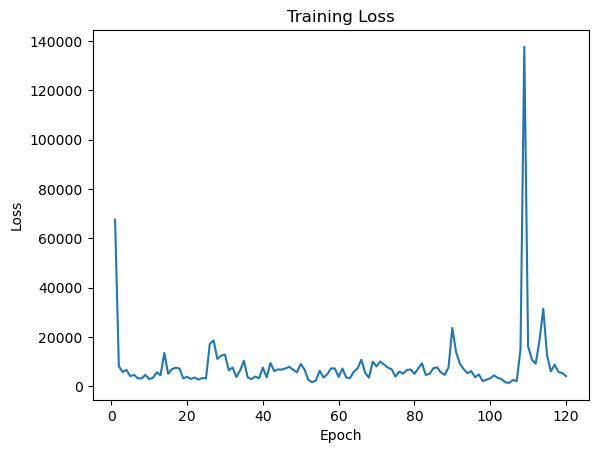

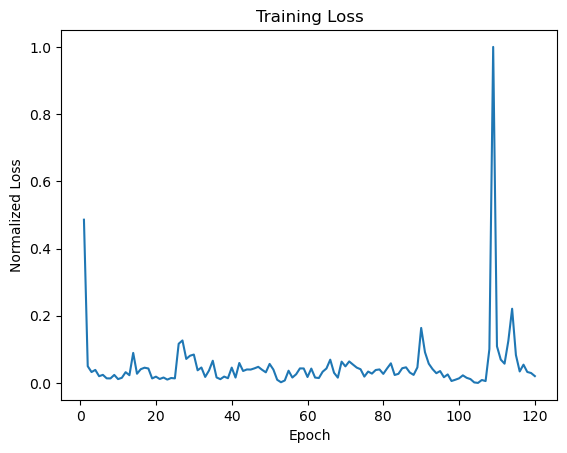

In [60]:
for epoch in range(num_epochs):
    total_loss = 0
    for i, (sequence, label) in enumerate(dataloader):
        sequence, label = sequence.float().cuda(), label.float().cuda()

        optimizer.zero_grad()

        output = model(sequence)

        # Extract labels for each output type
        pitch_label = label[:, 0].long()
        step_label = label[:, 1]
        duration_label = label[:, 2]

        loss = (
            loss_weights['pitch'] * losses['pitch'](output['pitch'], pitch_label) +
            loss_weights['step'] * losses['step'](output['step'].squeeze(), step_label) +
            loss_weights['duration'] * losses['duration'](output['duration'].squeeze(), duration_label)
        )

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (i+1) % len(dataloader) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

    avg_loss = total_loss / len(dataloader)  # if you want average loss per epoch
    loss_values.append(avg_loss)
    print(f"Average loss for epoch {epoch+1}: {avg_loss}")

torch.save(model.state_dict(), "newmodel.pt")

# plt.plot(loss_values)
# Converting to numpy array for easier mathematical operations
loss_values_np = np.array(loss_values)

# Min-Max normalization
loss_values_normalized = (loss_values_np - np.min(loss_values_np)) / (np.max(loss_values_np) - np.min(loss_values_np))

# Plotting
plt.plot(range(1, num_epochs + 1), loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(range(1, num_epochs + 1), loss_values_normalized)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.show()


In [61]:
model = MidiModel().cuda() 
model.load_state_dict(torch.load("newmodel.pt"))  # If "midi_model.pt" is in the same directory, no need to change this.
model.eval()


MidiModel(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True)
  (fc_pitch): Linear(in_features=256, out_features=128, bias=True)
  (fc_step): Linear(in_features=256, out_features=1, bias=True)
  (fc_duration): Linear(in_features=256, out_features=1, bias=True)
)

In [78]:
def predict_next_note(notes: torch.Tensor, model: MidiModel, temperature: float = 1.0) -> Tuple[int, float, float]:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = notes.unsqueeze(0).cuda()

    predictions = model(inputs)

    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = torch.multinomial(torch.softmax(pitch_logits, dim=-1), num_samples=1)
    pitch = pitch.squeeze().item()  # convert tensor to integer

    # `step` and `duration` values should be non-negative
    step = torch.max(step, torch.tensor([0.0], device=step.device)).item()  # convert tensor to float
    duration = torch.max(duration, torch.tensor([0.0], device=duration.device)).item()  # convert tensor to float

    return pitch, step, duration

# Define parameters
temperature = 2.0
num_predictions = 120

# Assuming that the dataset was not normalized. If it was, normalize `sample_notes` in the same way.
sample_notes = torch.from_numpy(all_notes.values).float()

# The initial sequence of notes
input_notes = sample_notes[:seq_length]

# List to store generated notes
generated_notes = []
prev_start = 0

# Generate notes
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = torch.tensor([pitch, step, duration, start, end])
    generated_notes.append(input_note.numpy())  # convert tensor to numpy array for use with pandas DataFrame
    input_notes = torch.cat([input_notes[1:], input_note.unsqueeze(0)], dim=0)  # Update input_notes
    prev_start = start

# Convert generated notes to a DataFrame
generated_notes = pd.DataFrame(generated_notes, columns=['pitch', 'step', 'duration', 'start', 'end'])

generated_notes.head(10)

,pitch,step,duration,start,end
0,69.0,34.313683,34.504250,34.313683,68.817932
1,53.0,1011.292053,1011.335815,1045.605713,2056.941650
2,54.0,2140.859619,2140.687012,3186.465332,5327.152344
3,51.0,3099.870850,3099.574463,6286.336426,9385.911133
4,112.0,3890.379639,3889.973389,10176.715820,14066.689453
5,13.0,4333.711426,4333.209473,14510.427734,18843.636719
6,122.0,4124.995117,4124.548828,18635.421875,22759.970703
7,113.0,4241.702148,4241.327148,22877.125000,27118.451172
8,12.0,4236.872070,4236.413086,27113.996094,31350.410156
9,123.0,4299.047852,4298.648926,31413.044922,35711.695312


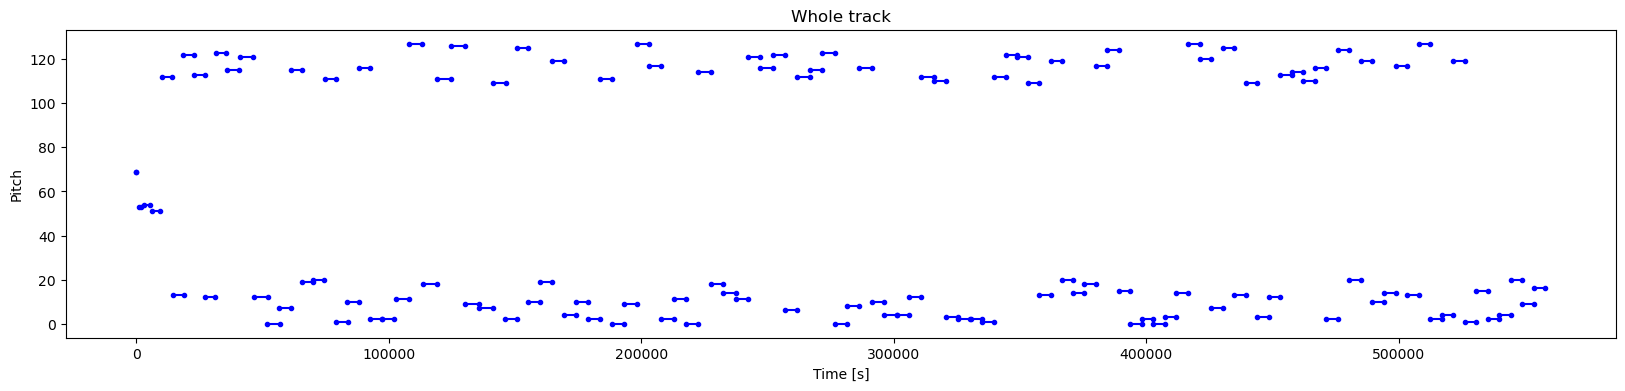

In [79]:
# This function is used to plot a piano roll of a MIDI track.
# Piano rolls are a good way to visualize MIDI data, showing the pitch of each note and its start and end times.
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  # If 'count' is provided, the function will only plot that many notes, and the title of the plot will reflect that.
  # If 'count' is not provided, the function will plot all notes in the track, and the title of the plot will say 'Whole track'.
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  
  # Setting the figure size for the plot.
  plt.figure(figsize=(20, 4))
  
  # The 'plot_pitch' array is used for the y-axis of the plot. It repeats the 'pitch' column of 'notes' twice along a new axis.
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  
  # The 'plot_start_stop' array is used for the x-axis of the plot. It contains the 'start' and 'end' columns of 'notes'.
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  
  # The 'plot' function is used to create the plot. It draws a blue dot for each note, and connects consecutive notes with blue lines.
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  
  # Labeling the x-axis as 'Time [s]' and the y-axis as 'Pitch'.
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  
  # Setting the title for the plot.
  _ = plt.title(title)

plot_piano_roll(generated_notes)

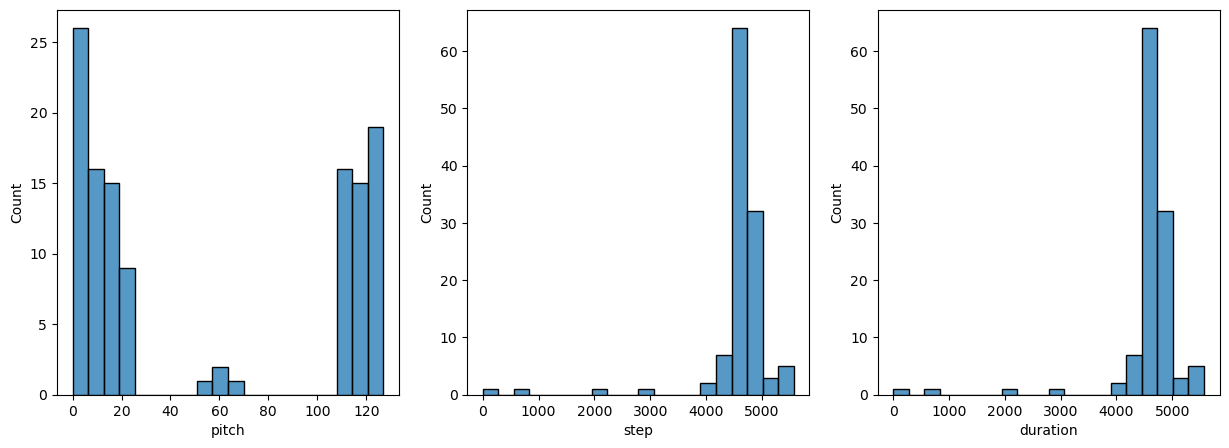

In [75]:
# This function plots the distributions of 'pitch', 'step', and 'duration' fields in a pandas DataFrame of notes from a MIDI file.
# By default, it drops the top 2.5 percentile of 'step' and 'duration' values when plotting their histograms to focus on the most common values.
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  # Setting the figure size for the plots.
  plt.figure(figsize=[15, 5])
  
  # Subplot for the 'pitch' distribution
  plt.subplot(1, 3, 1)  # This creates a subplot grid of 1 row and 3 columns, and selects the first plot for drawing.
  sns.histplot(notes, x="pitch", bins=20)  # This creates a histogram of 'pitch' values using Seaborn's histplot function.

  # Subplot for the 'step' distribution
  plt.subplot(1, 3, 2)  # Selects the second plot for drawing.
  max_step = np.percentile(notes['step'], 100 - drop_percentile)  # This calculates the (100 - drop_percentile) percentile of 'step' values.
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))  # This creates a histogram of 'step' values, with bins evenly spaced between 0 and max_step.

  # Subplot for the 'duration' distribution
  plt.subplot(1, 3, 3)  # Selects the third plot for drawing.
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)  # This calculates the (100 - drop_percentile) percentile of 'duration' values.
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))  # This creates a histogram of 'duration' values, with bins evenly spaced between 0 and max_duration.

plot_distributions(generated_notes)

In [ ]:
a
# Define a vectorized function that converts pitch numbers to note names using pretty_midi.note_number_to_name.
# np.vectorize applies a function to all elements in an array or sequence.
get_note_names = np.vectorize(pretty_midi.note_number_to_name)

# Use the vectorized function to convert all pitch values in the 'pitch' column of the raw_notes DataFrame to note names.
# The 'pitch' column contains numerical values representing the pitch of each note in MIDI notation.
sample_note_names = get_note_names(raw_notes['pitch'])

# Print the first 10 note names in the resulting array.
sample_note_names[:10]


In [ ]:
#run plot_piano_roll with the first 100 notes
plot_piano_roll(raw_notes, count=100)

In [ ]:
#run plot_piano_roll with the entire track
plot_piano_roll(raw_notes)

In [ ]:
plot_distributions(raw_notes)

In [ ]:
# a
# # This function converts a pandas DataFrame of notes back into a MIDI file using the pretty_midi library.
# # The 'notes' DataFrame should have 'pitch', 'step', and 'duration' columns.
# # 'pitch' is the pitch of the note, 'step' is the time interval since the start of the previous note, and 'duration' is the duration of the note.
# # 'out_file' is the path to the output MIDI file.
# # 'instrument_name' is the name of the instrument to be used in the MIDI file. This should be a string that matches one of the instrument names in the General MIDI standard.
# # 'velocity' is the loudness of the notes. It defaults to 100, and can range from 0 (silent) to 127 (maximum loudness).
# def notes_to_midi(
#   notes: pd.DataFrame,
#   out_file: str, 
#   instrument_name: str,
#   velocity: int = 100,  # note loudness
# ) -> pretty_midi.PrettyMIDI:

#   # Initialize a PrettyMIDI object.
#   pm = pretty_midi.PrettyMIDI()
  
#   # Create a PrettyMIDI instrument object with the specified name.
#   instrument = pretty_midi.Instrument(
#       program=pretty_midi.instrument_name_to_program(
#           instrument_name))

#   # Initialize the start time of the first note.
#   prev_start = 0
  
#   # Iterate over the rows of the notes DataFrame, each representing a note.
#   for i, note in notes.iterrows():
#     # Calculate the start and end times of the note in seconds.
#     start = float(prev_start + note['step'])
#     end = float(start + note['duration'])
    
#     # Create a PrettyMIDI Note object with the calculated start and end times, the specified velocity, and the pitch from the DataFrame.
#     note = pretty_midi.Note(
#         velocity=velocity,
#         pitch=int(note['pitch']),
#         start=start,
#         end=end,
#     )
    
#     # Append the note to the instrument's notes list.
#     instrument.notes.append(note)
    
#     # Update the start time for the next note.
#     prev_start = start

#   # Append the instrument to the PrettyMIDI object's instruments list.
#   pm.instruments.append(instrument)
  
#   # Write the PrettyMIDI object to a MIDI file.
#   pm.write(out_file)
  
#   # Return the PrettyMIDI object.
#   return pm


In [ ]:
# # In this section of the code, the 'notes_to_midi' function is used to convert the DataFrame 'raw_notes' back into a MIDI file.
# # The output MIDI file will be written to 'example.midi', and the instrument used will be the one specified by 'instrument_name'.
# # The 'notes_to_midi' function returns a PrettyMIDI object which is stored in 'example_pm' for further manipulation or analysis.

# # Specify the filename for the MIDI file to be created.
# example_file = 'example.midi'

# # Call the 'notes_to_midi' function with the DataFrame of notes, the output file name, and the instrument name.
# # The function will convert the DataFrame back into a MIDI file and write it to the specified location.
# # The resulting PrettyMIDI object is stored in 'example_pm'.
# example_pm = notes_to_midi(
#     raw_notes, out_file=example_file, instrument_name=instrument_name)


In [ ]:
# # Define the order of the columns in the DataFrame.
# key_order = ['pitch', 'step', 'duration']

# # Stack the columns of the DataFrame into a numpy array, with one column per axis.
# train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
# # Ensure that train_notes is a numpy array.
# train_notes = np.array(train_notes)

# # Convert the numpy array to a PyTorch tensor.
# train_notes_torch = torch.Tensor(train_notes)

# # Create a PyTorch Dataset from the tensor.
# notes_ds = TensorDataset(train_notes_torch)

# # Retrieve the first element in the dataset.
# first_element = notes_ds[0]

# # Print the shape and data type of the first element.
# print("Shape:", first_element[0].shape)
# print("dtype:", first_element[0].dtype)

# # Print the first element of the dataset.
# print(first_element)

In [ ]:
# def create_sequences(
#     dataset: torch.Tensor, 
#     seq_length: int,
#     vocab_size = 128,
#     batch_size = 32,
# ) -> DataLoader:
#     """Returns PyTorch DataLoader of sequence and label examples."""

#     def scale_pitch(x):
#         x = x.float()
#         x[:, 0] /= vocab_size
#         return x
    
#     seq_length += 1
#     sequences = []
#     labels = []

#     for i in range(0, len(dataset) - seq_length, seq_length):
#         sequence = dataset[i : i + seq_length]
#         # print (i)
#         # print (seq_length)
#         # print(sequence)
#         sequences.append(scale_pitch(sequence[0]))
#         # print(sequence)
#         labels.append(sequence[-1])
            
#     sequences = torch.stack(sequences)
#     # for i in range(len(sequences)):
#     #     print(len(sequences[i]))
#     # print (sequences[0])
#     labels = torch.stack(labels)
    
#     data = TensorDataset(sequences, labels)
#     data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    
#     return data_loader
    

#     def split_labels(sequences):
#         inputs = sequences[:-1]
#         labels_dense = sequences[-1]
#         labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

#         return scale_pitch(inputs), labels

#     split_data = [split_labels(sequence) for sequence in sequences]
#     return DataLoader(split_data, batch_size=32, shuffle=True)



In [ ]:
# def create_sequences(dataset, seq_length):
#     sequences = []
#     labels = []

#     # Extend the sequence length by one for the label
#     seq_length += 1

#     # Generate sequences and corresponding labels
#     for i in range(len(dataset) - seq_length):
#         seq = dataset[i:i+seq_length]
#         sequences.append(seq[:-1]) # the sequence
#         labels.append(seq[-1])     # the label is the last element of seq

#     # Convert lists to tensors
#     sequences = torch.stack(sequences)
#     labels = torch.stack(labels)

#     # !! Having issues Scale the pitch
#     # scale = torch.Tensor([vocab_size, 1.0, 1.0]).view(1, 3)  # Convert list to Tensor
#     # sequences[:, :, 0] = sequences[:, :, 0] / scale[0]

#     return sequences, labels

# # Convert the tensorflow dataset to numpy arrays

# # The values in notes_ds are tuples, so we have to do x[0] to get the tensor with pitch, step, and duration, and then with that tensor
# # We have to take the tensor[0] to get pitch, tensor[1] to get step, tensor[2] to get duration

# second = notes_ds[2]
# print(second[0].shape)
# print(second[0].dtype)


# notes_data = np.concatenate([x[0].numpy() for x in notes_ds])

# # Then convert the numpy arrays to PyTorch tensors
# notes_ds = torch.from_numpy(notes_data)

# # Create sequences
# seq_length = 25
# sequences, labels = create_sequences(notes_ds, seq_length)

# # One-hot encoding for pitch values of sequences and labels.
# sequences_onehot = F.one_hot(sequences[:, :, 0].to(torch.int64), num_classes=128)
# labels_onehot = F.one_hot(labels[:, 0].to(torch.int64), num_classes=128)

# # Replace the original pitch values in sequences and labels with the one-hot encoded versions.
# sequences = torch.cat((sequences_onehot, sequences[:, :, 1:]), dim=2)
# labels['pitch'] = labels_onehot


# # To inspect the shape of sequences and labels:
# for sequences, labels in seq_ds:
#     print("Sequences shape:", sequences.shape)
#     print("Labels shape:", labels.shape)
#     break

In [ ]:
# seq_length = 25
# vocab_size = 128
# seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [ ]:
# print(seq_ds)
# print(len(seq_ds))

# tempseq_ds = DataLoader(list(seq_ds), batch_size=32)

# first_batch_sequences, first_batch_labels = next(iter(tempseq_ds))
# print('First batch sequences shape:', first_batch_sequences.shape)
# print('First batch sequences elements (first 10):', first_batch_sequences[0, :5])
# print('First batch target:', first_batch_labels[0])

In [ ]:
# buffer_size = n_notes-seq_length # Set the buffer size
# batch_size = 64
# num_workers = 4

# train_ds = DataLoader(seq_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
# print(len(seq_ds))

In [ ]:
# def mse_with_positive_pressure(y_true: torch.Tensor, y_pred: torch.Tensor):
#     mse = (y_true - y_pred) ** 2
#     positive_pressure = 10 * torch.clamp(-y_pred, min=0.0)
#     return torch.mean(mse + positive_pressure)


In [ ]:
# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.lstm = nn.LSTM(input_size=3, hidden_size=128, batch_first=True)
#         self.pitch = nn.Linear(128, 128)
#         self.step = nn.Linear(128, 1)
#         self.duration = nn.Linear(128, 1)
        
#     def forward(self, inputs):
#         x, _ = self.lstm(inputs)
#         x = x[:, -1, :]  # get last output of each sequence
#         pitch = F.log_softmax(self.pitch(x), dim=1)
#         step = self.step(x)
#         duration = self.duration(x)
#         outputs = {'pitch': pitch, 'step': step, 'duration': duration}
#         return outputs
    
# def evaluate(model, data_loader, criterions):
#     model.eval() 
#     total_loss = 0
#     with torch.no_grad(): 
#         for inputs, targets in data_loader:
#             outputs = model(inputs)
#             loss_pitch = criterions['pitch'](outputs['pitch'], targets['pitch'])
#             loss_step = criterions['step'](outputs['step'], targets['step'])
#             loss_duration = criterions['duration'](outputs['duration'], targets['duration'])
#             loss = loss_pitch + loss_step + loss_duration
#             print(loss_pitch.shape)
#             print(loss_step.shape)
#             print(loss_duration.shape)
#             total_loss += loss.item()
#     return total_loss / len(data_loader)

# # class MyDataset(Dataset):
# #     def __init__(self, inputs, targets):
# #         self.inputs = inputs
# #         self.targets = targets

# #     def __len__(self):
# #         return len(self.inputs)

# #     def __getitem__(self, idx):
# #         return self.inputs[idx], {k: v[idx] for k, v in self.targets.items()}

# class MyDataset(Dataset):
#     def __init__(self, inputs, targets):
#         self.inputs = inputs
#         self.targets = targets

#     def __len__(self):
#         return len(self.inputs)

#     def __getitem__(self, idx):
#         target_dict = {'pitch': self.targets[idx, 0],
#                        'step': self.targets[idx, 1],
#                        'duration': self.targets[idx, 2]}
#         return self.inputs[idx], target_dict


# # Instantiate model and print the structure
# model = MyModel()
# print(model)

# # Define optimizer
# learning_rate = 0.005
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Define loss functions
# criterion_pitch = nn.NLLLoss()  # Negative Log Likelihood Loss
# criterion_step = mse_with_positive_pressure
# criterion_duration = mse_with_positive_pressure
# criterions = {'pitch': criterion_pitch, 'step': criterion_step, 'duration': criterion_duration}



In [ ]:
# sequence_length = 26 

# inputs = []
# targets = []

# #train_notes has a tensor size of 3
# for i in range(0, len(train_notes) - sequence_length):
#     inputs.append(train_notes[i:i + sequence_length])
#     targets.append(train_notes[i + sequence_length])

# # Convert lists to numpy arrays
# inputs = np.array(inputs, dtype = np.float32)
# targets = torch.Tensor(targets).long()

# # Now you have your inputs and targets, which you can use in the model
# print(inputs.shape)
# print(targets.shape)

# # # Create a DataLoader (replace with your actual data)
# dataset = MyDataset(inputs, targets)
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# # # Training loop
# epochs = 10
# for epoch in range(epochs):
#     running_loss = 0.0
#     for inputs, targets in data_loader:
#         # Clear the gradients
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model(inputs)
#         # Compute loss
#         loss_pitch = criterion_pitch(outputs['pitch'], targets['pitch'])
#         loss_step = criterion_step(outputs['step'], targets['step'])
#         loss_duration = criterion_duration(outputs['duration'], targets['duration'])
#         # Combine the losses
#         loss = loss_pitch + loss_step + loss_duration
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
#         # Print statistics
#         running_loss += loss.item()
#     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, running_loss/len(data_loader)))


In [ ]:
# dataset = MyDataset(inputs, targets)
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# print(len(train_ds))
# # losses = evaluate(model, train_ds, criterions)
# # print("Losses: ", losses)

In [ ]:
# from sklearn.model_selection import train_test_split

# # Convert sequences and labels to DataLoader
# seq_ds = DataLoader(list(zip(sequences, labels)), batch_size=32)

# # To inspect the shape of sequences and labels:
# for sequences, labels in seq_ds:
#     print("Sequences shape:", sequences.shape)
#     print("Labels shape:", labels.shape)
#     break

# # Now, you should split your `sequences` and `labels` into a training and validation set:
# train_inputs, val_inputs, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# # Then, you can create your datasets
# train_dataset = MyDataset(train_inputs, train_labels)
# val_dataset = MyDataset(val_inputs, val_labels)

# # And your DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# # Split each target
# train_targets_pitch, val_targets_pitch = train_test_split(targets['pitch'], test_size=0.2, random_state=42)
# train_targets_step, val_targets_step = train_test_split(targets['step'], test_size=0.2, random_state=42)
# train_targets_duration, val_targets_duration = train_test_split(targets['duration'], test_size=0.2, random_state=42)

# # Combine targets into dictionary
# train_targets = {'pitch': train_targets_pitch, 'step': train_targets_step, 'duration': train_targets_duration}
# val_targets = {'pitch': val_targets_pitch, 'step': val_targets_step, 'duration': val_targets_duration}

# # Create your datasets
# train_dataset = MyDataset(train_inputs, train_targets)
# val_dataset = MyDataset(val_inputs, val_targets)

# # Create your DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# print(targets['pitch'].shape)
# print(targets['step'].shape)
# print(targets['duration'].shape)

# print(train_targets_pitch.shape, val_targets_pitch.shape)
# print(train_targets_step.shape, val_targets_step.shape)
# print(train_targets_duration.shape, val_targets_duration.shape)



In [ ]:
# class Callbacks:
#     def __init__(self, patience=7, verbose=False, checkpoint_path='./training_checkpoints/ckpt_'):
#         self.early_stopping = EarlyStopping(patience, verbose)
#         self.checkpoint_path = checkpoint_path

#     def check(self, epoch, loss, model):
#         self.early_stopping(loss, model)
#         self.save_checkpoint(epoch, model)
#         return self.early_stopping.early_stop

#     def save_checkpoint(self, epoch, model):
#         '''Saves model when a new epoch starts'''
#         torch.save(model.state_dict(), self.checkpoint_path + str(epoch+1))

# class EarlyStopping:
#     def __init__(self, patience=7, verbose=False, delta=0):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.delta = delta

#     def __call__(self, val_loss, model):

#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             if self.verbose:
#                 print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}).  Saving model ...')
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.counter = 0

# val_dataset = MyDataset(val_inputs, val_targets)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Usage in your training loop:
# callbacks = Callbacks(patience=5, verbose=True)

# for epoch in range(epochs):
#     # Training steps
#     # ...

#     # Validation steps
#     val_loss = evaluate(model, val_loader, criterions)
#     print("Validation Loss:", val_loss)

#     # Callbacks check
#     if callbacks.check(epoch, val_loss, model):
#         print("Early stopping")
#         break


In [ ]:
# import time

# # Start timing
# start_time = time.time()

# # Number of epochs
# epochs = 50

# # Initialize the Callbacks
# callbacks = Callbacks(patience=5, verbose=True)

# # Training Loop
# for epoch in range(epochs):
#     running_loss = 0.0
#     # Training steps
#     for inputs, targets in train_ds:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss_pitch = criterion_pitch(outputs['pitch'], targets['pitch'])
#         loss_step = criterion_step(outputs['step'], targets['step'])
#         loss_duration = criterion_duration(outputs['duration'], targets['duration'])
#         loss = loss_pitch + loss_step + loss_duration
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
    
#     # Validation steps
#     val_loss = evaluate(model, val_loader)
#     print("Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, epochs, running_loss/len(train_ds), val_loss))
    
#     # Check the callbacks
#     callbacks.step(epoch, model, val_loss)

# # End timing
# end_time = time.time()

# print("Training Time: %s seconds" % (end_time - start_time))


In [ ]:
# plt.plot(history.epoch, history.history['loss'], label='total loss')
# plt.show()

In [ ]:
# def predict_next_note(
#     notes: np.ndarray, 
#     keras_model: tf.keras.Model, 
#     temperature: float = 1.0) -> int:
#   """Generates a note IDs using a trained sequence model."""

#   assert temperature > 0

#   # Add batch dimension
#   inputs = tf.expand_dims(notes, 0)

#   predictions = model.predict(inputs)
#   pitch_logits = predictions['pitch']
#   step = predictions['step']
#   duration = predictions['duration']

#   pitch_logits /= temperature
#   pitch = tf.random.categorical(pitch_logits, num_samples=1)
#   pitch = tf.squeeze(pitch, axis=-1)
#   duration = tf.squeeze(duration, axis=-1)
#   step = tf.squeeze(step, axis=-1)

#   # `step` and `duration` values should be non-negative
#   step = tf.maximum(0, step)
#   duration = tf.maximum(0, duration)

#   return int(pitch), float(step), float(duration)

In [ ]:
# temperature = 2.0
# num_predictions = 120

# sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# # The initial sequence of notes; pitch is normalized similar to training
# # sequences
# input_notes = (
#     sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

# generated_notes = []
# prev_start = 0
# for _ in range(num_predictions):
#   pitch, step, duration = predict_next_note(input_notes, model, temperature)
#   start = prev_start + step
#   end = start + duration
#   input_note = (pitch, step, duration)
#   generated_notes.append((*input_note, start, end))
#   input_notes = np.delete(input_notes, 0, axis=0)
#   input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
#   prev_start = start

# generated_notes = pd.DataFrame(
#     generated_notes, columns=(*key_order, 'start', 'end'))


In [ ]:
# generated_notes.head(10)

In [ ]:
# midi_output = pretty_midi.PrettyMIDI()

# # Create an instrument instance for a piano
# piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
# piano = pretty_midi.Instrument(program=piano_program)

# # Iterate through the generated notes
# for index, row in generated_notes.iterrows():
#     pitch, step, duration, start, end = row

#     # Create a Note instance for the current note
#     note = pretty_midi.Note(velocity=100, pitch=int(pitch), start=start, end=end)

#     # Add the note to the piano instrument
#     piano.notes.append(note)

# # Add the piano instrument to the PrettyMIDI object
# midi_output.instruments.append(piano)

# # Save the MIDI file
# # Save the MIDI file
# with open('output.mid', 'wb') as midi_file:
#     midi_file.write(midi_output.synthesize())
